In [20]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils import get_spike_activity, sdf, sdf_mean, sdf_maf
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as st
import pandas as pd

In [40]:
result_path = "/home/nomodel/code/NODS/results/grid_search/"
min = 4
max = 5
dim = 3
folder = f'grid_NO/'
result_path = os.path.join(result_path,folder)
with open("/home/nomodel/code/NODS/network_configuration.json", "r") as json_file:
    net_config = json.load(json_file)

In [ ]:
values_min = np.array([7*10**-4, 5*10**-4, 3*10**-4])
values_plus = np.array([1.1*10**-4, 9*10**-5, 7*10**-5])

values_min = ["{:.1e}".format(val) for val in values_min]
values_plus = ["{:.1e}".format(val) for val in values_plus]

In [30]:
CS_burst_dur = net_config["devices"]["CS"]["parameters"]["burst_dur"]
CS_start_first = float(net_config["devices"]["CS"]["parameters"]["start_first"])
between_start = net_config["devices"]["CS"]["parameters"]["between_start"]
n_trials = net_config["devices"]["CS"]["parameters"]["n_trials"]
US_start_first = float(net_config["devices"]["US"]["parameters"]["start_first"])

In [ ]:
cell = "pc_spikes"

grid_search = np.zeros((dim,dim))
grid_frequency = np.zeros((dim,dim))
grid_learning = np.zeros((dim,dim))
grid_baseline = np.zeros((dim,dim))

for i in range(0,dim+1):
    for j in range(0,dim+1):
        file_path = result_path + f"min{i}_plus{j}"

        spk = get_spike_activity(cell_name=cell, path=file_path)
        sdf_mean_over_trials = []
        sdf_baseline = np.zeros((n_trials))
        sdf_cr = np.zeros((n_trials))
        for trial in range(n_trials):

            start = trial * between_start
            stop = CS_start_first + CS_burst_dur + trial * between_start

            sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
            sdf_mean_trial = sdf_mean(sdf_cells)
            sdf_mean_over_trials.append(sdf_mean_trial)
            sdf_baseline[trial] = np.mean(sdf_mean_trial[100:150])
            sdf_cr[trial] = np.mean(sdf_mean_trial[250:300])

        sdf_change_baseline = sdf_baseline[1:] - sdf_baseline[1]
        sdf_change_cr = sdf_cr[1:] - sdf_cr[1]
    
        # learning in respect to the baseline
        grid_search[i-1,j-1] = (np.median(sdf_change_baseline[-10:]) - np.median(sdf_change_cr[-10:]))
        # pc frequency
        grid_frequency[i-1,j-1] = sdf_cr[-1]
        # percentage change baseline
        grid_baseline[i-1,j-1]  = (np.median(sdf_baseline[1:10])-np.median(sdf_baseline[-10:]))/np.median(sdf_baseline[1:10])*100
        # percentage learning CR
        grid_learning[i-1,j-1]  = (np.median(sdf_cr[1:10])-np.median(sdf_cr[-10:]))/np.median(sdf_cr[1:10])*100

In [8]:
cell = "pc_spikes"

min = [8,7,5,4,3,1]
plus = [11,9,8,7,4,1]
values_min = min
values_plus = plus

grid_search = np.nan*np.ones((len(min),len(plus)))
grid_frequency = np.zeros((len(min),len(plus)))
grid_learning = np.zeros((dim,dim))
grid_baseline = np.zeros((dim,dim))
sim_baseline = np.zeros((len(min),len(plus),100))
sim_cr = np.zeros((len(min),len(plus),100))
sim_frq = np.zeros((len(min),len(plus),10))




for i,m in enumerate(min):
    for j,p in enumerate(plus):
        folder_path = result_path + f"min{m}_plus{p}/"
        if not os.path.exists(folder_path):
            continue
        for k in range (0,10):
            file_path = folder_path+ f"{k}/"

            spk = get_spike_activity(cell_name=cell, path=file_path)
            sdf_mean_over_trials = []
            
            sdf_baseline = np.zeros((n_trials))
            sdf_cr = np.zeros((n_trials))
            for trial in range(n_trials):

                #print(f'trial {trial}, sim {k}, min {m}, plus {p}')
                start = trial * between_start
                stop = CS_start_first + CS_burst_dur + trial * between_start

                sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
                sdf_mean_trial = sdf_mean(sdf_cells)
                sdf_mean_over_trials.append(sdf_mean_trial)
                sdf_baseline[trial] = np.mean(sdf_mean_trial[150:200])
                sdf_cr[trial] = np.mean(sdf_mean_trial[250:300])

            sdf_change_baseline = sdf_baseline[1:] - sdf_baseline[1]
            sdf_change_cr = sdf_cr[1:] - sdf_cr[1]
        
            sim_baseline[i,j,k*10:(k+1)*10] = sdf_change_baseline[-10:]
            sim_cr[i,j,k*10:(k+1)*10] = sdf_change_cr[-10:]
            sim_frq[i,j,k] = sdf_cr[-1]

        # learning in respect to the baseline
        grid_search[i,j] = (np.median(sim_baseline[i,j]) - np.median(sim_cr[i,j]))
        # pc frequency
        grid_frequency[i,j] = np.median(sim_frq[i,j])

In [9]:
import pickle

with open ('grid_search.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

with open ('grid_frequency.pkl', 'wb') as f:
    pickle.dump(grid_frequency, f)

In [ ]:
for i in range(0,3):
    for j in range(0,3):
        sdf_mean_trials_simulations = []
        for k in range(0,10):

            file_path = result_path + f"min{i}_plus{j}/min{i}_plus{j}_{k}/"
            spk = get_spike_activity(cell_name=cell, path=file_path)

            sdf_mean_over_trials = []
            step = 5
            for trial in range(n_trials):
                start = trial * between_start
                stop = CS_start_first + CS_burst_dur + trial * between_start
                sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
                sdf_mean_trial = sdf_mean(sdf_cells)
                t_sim = len(sdf_mean_trial)
                sdf_mean_over_trials.append(sdf_mean_trial)

            sdf_mean_trials_simulations.append(sdf_mean_over_trials)
        
        sdf_mean_trials_simulations = np.array(sdf_mean_trials_simulations)
        sdf_concatenated = np.zeros(t_sim)

        palette = list(reversed(sns.color_palette("viridis", n_trials).as_hex()))
        sm = plt.cm.ScalarMappable(
        cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=n_trials)
        )
        
        fig = plt.figure()
        
        for trial in range(n_trials):
            concatenated_time = []
            for t in range(t_sim):
                for sim in range(0,10):
                    concatenated_time.append(sdf_mean_trials_simulations[sim,trial,t]) 
                sdf_concatenated[t] = np.median(concatenated_time)
            
            plt.plot(sdf_concatenated, palette[trial])
        plt.title(cell)
        plt.xlabel("Time [ms]")
        plt.ylabel("SDF [Hz]")
        plt.axvline(CS_start_first, label="CS start", c="grey")
        plt.axvline(US_start_first - between_start, label="US start", c="black")
        plt.axvline(CS_start_first + CS_burst_dur, label="CS & US end ", c="red")
        plt.legend()
        plt.colorbar(sm, label="Trial")
        fig.savefig(os.path.join(result_path,f'aa_sdf_{cell}_min{i}_plus{j}.png'))

In [ ]:
for i in range(0,4):
    for j in range(0,4):

        file_path = result_path + f"min{i}_plus{j}/"
        spk = get_spike_activity(cell_name=cell, path=file_path)

        palette = list(reversed(sns.color_palette("viridis", n_trials).as_hex()))
        sm = plt.cm.ScalarMappable(
        cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=n_trials)
        )
        sdf_mean_cell = []
        sdf_maf_cell = []
        step = 5
        for trial in range(n_trials):
            start = trial * between_start
            stop = CS_start_first + CS_burst_dur + trial * between_start
            sdf_cell = sdf(start=start, stop=stop, spk=spk, step=step)
            sdf_mean_cell.append(sdf_mean(sdf_cell))
            sdf_maf_cell.append(sdf_maf(sdf_cell))

        fig = plt.figure()
        for trial in range(n_trials):
            plt.plot(sdf_mean_cell[trial], palette[trial])
        plt.title(cell)
        plt.xlabel("Time [ms]")
        plt.ylabel("SDF [Hz]")
        plt.axvline(CS_start_first, label="CS start", c="grey")
        plt.axvline(US_start_first - between_start, label="US start", c="black")
        plt.axvline(CS_start_first + CS_burst_dur, label="CS & US end ", c="red")
        plt.legend()
        plt.colorbar(sm, label="Trial")
        fig.savefig(os.path.join(result_path,f'aa_sdf_{cell}_min{i}_plus{j}.png'))

In [35]:
cell = "pc_spikes"

min = [8,7,5,4,3,1]
plus = [11,9,8,7,4,1]

for i,m in enumerate(min):
    for j,p in enumerate(plus):
        folder_path = result_path + f"min{m}_plus{p}/"
        if not os.path.exists(folder_path):
            continue

        sdf_mean_trials_simulations = []

        for k in range(0, 10):
            file_path = os.path.join(folder_path, f"{k}/")
            spk = get_spike_activity(cell_name=cell, path=file_path)

            sdf_mean_over_trials = []
            step = 5
            for trial in range(n_trials):
                start = trial * between_start
                stop = CS_start_first + CS_burst_dur + trial * between_start
                sdf_cells = sdf(start=start, stop=stop, spk=spk, step=step)
                sdf_mean_trial = sdf_mean(sdf_cells)
                sdf_mean_over_trials.append(sdf_mean_trial)

            sdf_mean_trials_simulations.append(sdf_mean_over_trials)
        
        sdf_mean_trials_simulations = np.array(sdf_mean_trials_simulations)
        t_sim = sdf_mean_trials_simulations.shape[2]
        sdf_concatenated = np.zeros(t_sim)

        palette = list(reversed(sns.color_palette("viridis", n_trials).as_hex()))
        sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=n_trials))

        fig = plt.figure()

        for trial in range(n_trials):
            concatenated_time = []
            for t in range(t_sim):
                concatenated_time = sdf_mean_trials_simulations[:, trial, t].tolist()
                sdf_concatenated[t] = np.median(concatenated_time)

            plt.plot(sdf_concatenated, color=palette[trial])

        plt.title(cell)
        plt.xlabel("Time [ms]")
        plt.ylabel("SDF [Hz]")
        plt.axvline(CS_start_first, label="CS start", c="grey")
        plt.axvline(US_start_first - between_start, label="US start", c="black")
        plt.axvline(CS_start_first + CS_burst_dur, label="CS & US end", c="red")
        plt.legend()
        plt.colorbar(sm, label="Trial")
        fig.savefig(os.path.join(result_path, f'aa_sdf_{cell}_min{m}_plus{p}.png'))
        plt.close(fig)

/tmp/ipykernel_861373/167086067.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Trial")


In [10]:
grid_search

array([[384.        , 373.        ,   3.60543972, 350.        ,
          4.16143171,  -0.43931641],
       [  2.63124473,   1.80248124,  -0.83856277,   3.58198024,
         -1.41111155, 240.        ],
       [  4.88975277,   4.51418414,   1.51464308,   2.27072584,
          2.48872605, 175.        ],
       [162.        ,   2.39515729,   6.37210629,   1.25935593,
          4.49732517,   2.5534925 ],
       [  2.02317282,   2.87437294,   1.63418657,   3.50295576,
          0.73804369,  28.        ],
       [ 22.        ,  18.        ,   2.38769051,  10.        ,
          2.53813165,   1.9996108 ]])

In [13]:
grid_search_new = np.copy(grid_search)
grid_search_new[grid_search_new > 7] = np.nan
grid_search_new

array([[        nan,         nan,  3.60543972,         nan,  4.16143171,
        -0.43931641],
       [ 2.63124473,  1.80248124, -0.83856277,  3.58198024, -1.41111155,
                nan],
       [ 4.88975277,  4.51418414,  1.51464308,  2.27072584,  2.48872605,
                nan],
       [        nan,  2.39515729,  6.37210629,  1.25935593,  4.49732517,
         2.5534925 ],
       [ 2.02317282,  2.87437294,  1.63418657,  3.50295576,  0.73804369,
                nan],
       [        nan,         nan,  2.38769051,         nan,  2.53813165,
         1.9996108 ]])

In [ ]:
np.median(grid_search)

In [18]:
grid_frequency

array([[377.        , 364.        , 131.80470124, 346.        ,
        129.96105785, 200.46210754],
       [137.39118661, 136.75779792, 198.76017126, 136.42896689,
        198.06113163, 247.        ],
       [145.0323428 , 145.6829245 , 190.07935948, 144.72168963,
        188.51783442, 190.        ],
       [175.        , 185.54188733, 149.04829412, 185.87930423,
        148.34960344, 147.74405502],
       [156.12249922, 154.63986932, 179.35409957, 152.9119103 ,
        180.13603172,  62.        ],
       [ 52.        ,  41.        , 163.3690519 ,  19.        ,
        161.43044824, 160.66620714]])

In [ ]:
grid_learning

/tmp/ipykernel_861373/413724497.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


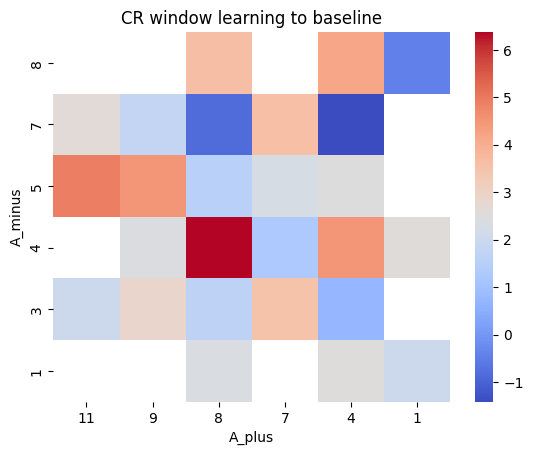

In [16]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_search_new, cmap = cmap, xticklabels=values_plus, yticklabels=values_min)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('CR window learning to baseline')
plt.savefig(os.path.join(result_path,'heatmap_baseline-CR'))

/tmp/ipykernel_861373/183677828.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


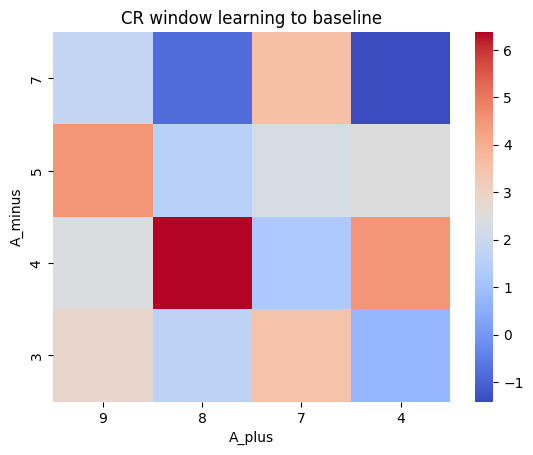

In [17]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_search[1:5,1:5], cmap = cmap, xticklabels=values_plus[1:5], yticklabels=values_min[1:5])
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('CR window learning to baseline')
plt.savefig(os.path.join(result_path,'heatmap_baseline-CR_zoom'))


/tmp/ipykernel_861373/1013634547.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot')


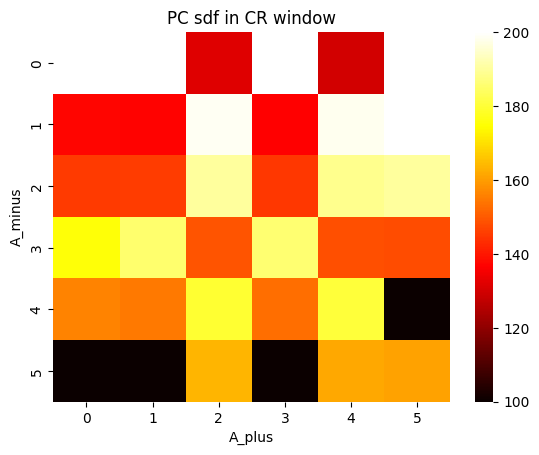

In [19]:
cmap = plt.cm.get_cmap('hot')
sns.heatmap(grid_frequency, cmap = cmap, vmin = 100, vmax = 200)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('PC sdf in CR window')
plt.savefig(os.path.join(result_path,'heatmap_frequency_PC'))

In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_learning, cmap = cmap, vmin = 0, vmax = 3, xticklabels=values_plus, yticklabels=values_min)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('%LTD in CR window')
plt.savefig(os.path.join(result_path,'heatmap_CR'))

In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_baseline, cmap = cmap, vmin = -3, vmax = 0, xticklabels=values_plus, yticklabels=values_min)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('%LTD in baseline')
plt.savefig(os.path.join(result_path,'heatmap_baseline'))

In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
sns.heatmap(grid_learning-grid_baseline, cmap = cmap, vmin = 0, vmax = 4, xticklabels=values_plus, yticklabels=values_min)
plt.xlabel('A_plus')
plt.ylabel('A_minus')
plt.title('%LTD difference')
plt.savefig(os.path.join(result_path,'heatmap_difference'))

In [ ]:
np.logspace(-3,-6, 6)

In [ ]:
cell = "pc_spikes"

grid_search = np.zeros((dim,dim))
grid_frequency = np.zeros((dim,dim))
grid_learning = np.zeros((dim,dim))
grid_baseline = np.zeros((dim,dim))

for i in range(0,dim+1):
    for j in range(0,dim+1):
        for k in range (0,10):
            file_path = result_path + f"min{i}_plus{j}/min{i}_plus{j}_{k}"

            spk = get_spike_activity(cell_name=cell, path=file_path)
            sdf_mean_over_trials = []
            sdf_baseline = np.zeros((n_trials))
            sdf_cr = np.zeros((n_trials))
            for trial in range(n_trials):

                start = trial * between_start
                stop = CS_start_first + CS_burst_dur + trial * between_start

                sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
                sdf_mean_trial = sdf_mean(sdf_cells)
                sdf_mean_over_trials.append(sdf_mean_trial)
                sdf_baseline[trial] = np.mean(sdf_mean_trial[100:150])
                sdf_cr[trial] = np.mean(sdf_mean_trial[250:300])

            sdf_change_baseline = sdf_baseline[1:] - sdf_baseline[1]
            sdf_change_cr = sdf_cr[1:] - sdf_cr[1]
        
            # learning in respect to the baseline
            grid_search[i-1,j-1] = (np.median(sdf_change_baseline[-10:]) - np.median(sdf_change_cr[-10:]))
            # pc frequency
            grid_frequency[i-1,j-1] = sdf_cr[-1]
            # percentage change baseline
            grid_baseline[i-1,j-1]  = (np.median(sdf_baseline[1:10])-np.median(sdf_baseline[-10:]))/np.median(sdf_baseline[1:10])*100
            # percentage learning CR
            grid_learning[i-1,j-1]  = (np.median(sdf_cr[1:10])-np.median(sdf_cr[-10:]))/np.median(sdf_cr[1:10])*100

In [ ]:
file_path = result_path + f"min{1}_plus{1}/min{1}_plus{1}_{0}/"
spk = get_spike_activity(cell_name=cell, path=file_path)

sdf_mean_over_trials = []
step = 5
for trial in range(n_trials):
    start = trial * between_start
    stop = CS_start_first + CS_burst_dur + trial * between_start
    sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
    sdf_mean_trial = sdf_mean(sdf_cells)
    t_sim = len(sdf_mean_trial)
    sdf_mean_over_trials.append(sdf_mean_trial)
    sdf_mean_cell.append(sdf_mean(sdf_cells))

"""sdf_mean_trials_simulations.append(sdf_mean_over_trials)

sdf_mean_trials_simulations = np.array(sdf_mean_trials_simulations)
sdf_concatenated = np.zeros(t_sim)"""

palette = list(reversed(sns.color_palette("viridis", n_trials).as_hex()))
sm = plt.cm.ScalarMappable(
cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=n_trials)
)

fig = plt.figure()
for trial in range(n_trials):
    plt.plot(sdf_mean_cell[trial], palette[trial])
plt.title(cell)
plt.xlabel("Time [ms]")
plt.ylabel("SDF [Hz]")
plt.axvline(CS_start_first, label="CS start", c="grey")
plt.axvline(US_start_first - between_start, label="US start", c="black")
plt.axvline(CS_start_first + CS_burst_dur, label="CS & US end ", c="red")
plt.legend()
plt.colorbar(sm, label="Trial")
fig.savefig(os.path.join(result_path,f'aa_sdf_{cell}_min{i}_plus{j}.png'))

In [41]:
cell = "pc_spikes"

file_path = result_path + f"min4_plus8/"

spk = get_spike_activity(cell_name=cell, path=file_path)
sdf_mean_over_trials = []

sdf_baseline = np.zeros((n_trials))
sdf_cr = np.zeros((n_trials))
for trial in range(n_trials):

    #print(f'trial {trial}, sim {k}, min {m}, plus {p}')
    start = trial * between_start
    stop = CS_start_first + CS_burst_dur + trial * between_start

    sdf_cells = sdf(start=start, stop=stop, spk=spk, step=5)
    sdf_mean_trial = sdf_mean(sdf_cells)
    sdf_mean_over_trials.append(sdf_mean_trial)
    sdf_baseline[trial] = np.mean(sdf_mean_trial[150:200])
    sdf_cr[trial] = np.mean(sdf_mean_trial[250:300])

sdf_change_baseline = sdf_baseline[1:] - sdf_baseline[1]
sdf_change_cr = sdf_cr[1:] - sdf_cr[1]

median = np.median(sdf_change_baseline[-10:])-np.median(sdf_change_cr[-10:])

In [42]:
median

3.2976592166603638

## A_minus = -0.0005
## A_plus = 0.0000225